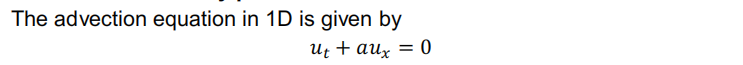

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
#
from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade

In [ ]:
tf.keras.backend.set_floatx("float64")

### creating data 

In [ ]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1)

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5)
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

Text(0.5, 1.0, 'Data points (BCs & IC)')

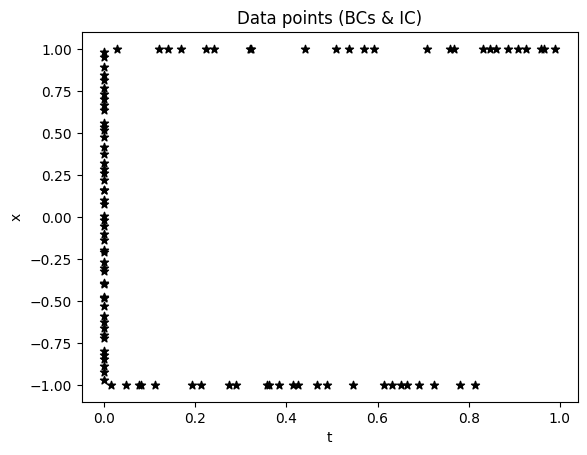

In [ ]:
# view randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="*", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

### Boundary conditions

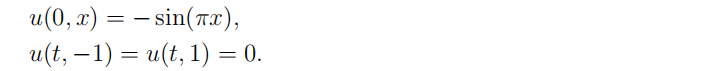

In [ ]:
# output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

In [ ]:
# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5)

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

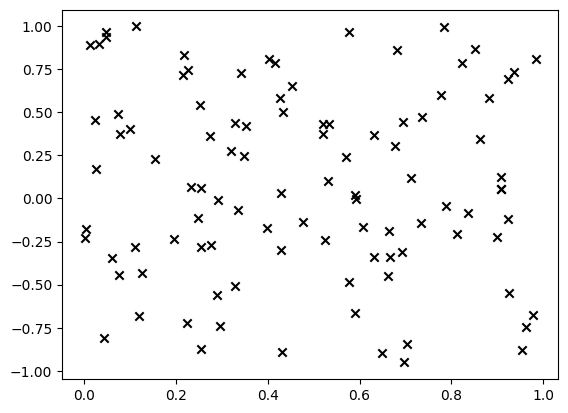

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(t_c[0:100] , x_c[0:100] , marker="x", c="k")

In [ ]:
# convert all data and collocation points to tf.Tensor
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [ ]:
### model design
import tensorflow as tf
neuron_per_layer = 20
# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,))

# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden8)

model = tf.keras.Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

In [ ]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(t, x):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model(tf.concat([t, x], axis=1)) # note the axis ; `column`
    return u

In [ ]:
# the physics informed loss function
# IMPORTANT: this loss function is used for collocation points
@tf.function
def f(t, x):
    u0 = u(t, x)
    u_t = tf.gradients(u0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    F = u_t + (0.01/np.pi)*u_x
    return tf.reduce_mean(tf.square(F))

In [ ]:
# MSE loss function
# IMPORTANT: this loss function is used for data points
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

In [ ]:
import time

In [ ]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 1000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = f(t_c, x_c)
        # MSE loss for data points # boundary loss
        L2 = mse(y_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

epoch -    0 /1000 : 0.298
epoch -   10 /1000 : 0.206
epoch -   20 /1000 : 0.195
epoch -   30 /1000 : 0.191
epoch -   40 /1000 : 0.187
epoch -   50 /1000 : 0.181
epoch -   60 /1000 : 0.172
epoch -   70 /1000 : 0.159
epoch -   80 /1000 : 0.141
epoch -   90 /1000 : 0.119
epoch -  100 /1000 : 0.096
epoch -  110 /1000 : 0.073
epoch -  120 /1000 : 0.047
epoch -  130 /1000 : 0.028
epoch -  140 /1000 : 0.017
epoch -  150 /1000 : 0.010
epoch -  160 /1000 : 0.007
epoch -  170 /1000 : 0.005
epoch -  180 /1000 : 0.004
epoch -  190 /1000 : 0.003
epoch -  200 /1000 : 0.003
epoch -  210 /1000 : 0.002
epoch -  220 /1000 : 0.002
epoch -  230 /1000 : 0.002
epoch -  240 /1000 : 0.002
epoch -  250 /1000 : 0.001
epoch -  260 /1000 : 0.002
epoch -  270 /1000 : 0.001
epoch -  280 /1000 : 0.001
epoch -  290 /1000 : 0.001
epoch -  300 /1000 : 0.001
epoch -  310 /1000 : 0.001
epoch -  320 /1000 : 0.001
epoch -  330 /1000 : 0.001
epoch -  340 /1000 : 0.001
epoch -  350 /1000 : 0.001
epoch -  360 /1000 : 0.001
e

Text(0.5, 0, 'epoch')

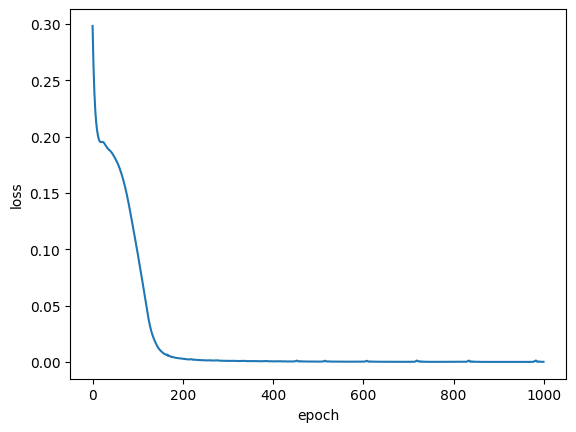

In [ ]:
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

## Predicted solution 

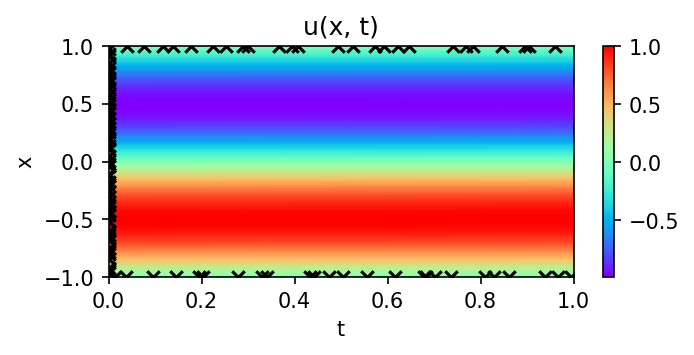

In [ ]:
### plot
# another code is also available for ploting
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=150)
S = u(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

63/63 [==============================] - 0s 2ms/step


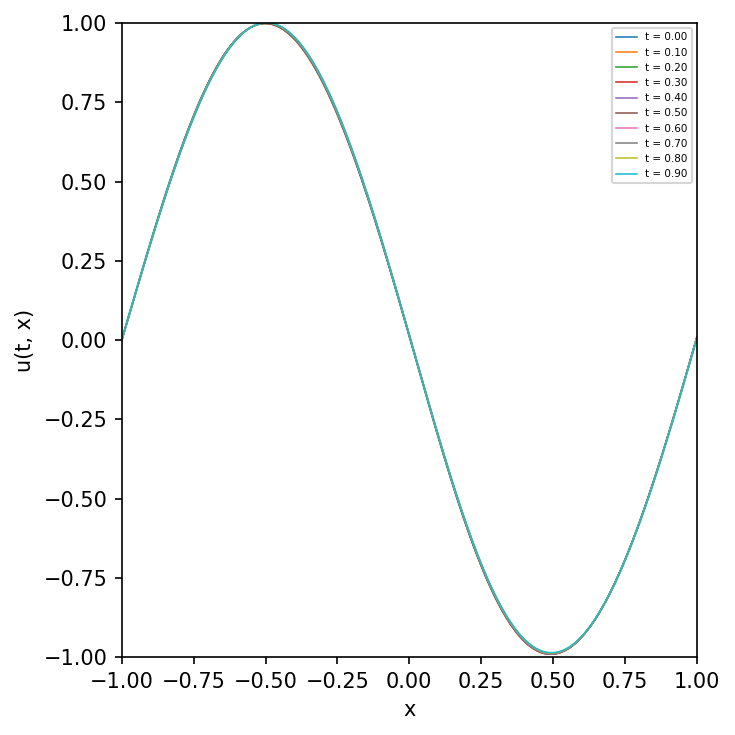

In [ ]:


plt.figure(figsize=(5, 5), dpi=150)
# input shape
n_temporal, n_spatial = 10, 2000
# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)
# change t
for i in range(n_temporal):
    v[:, 0] = i/n_temporal
    plt.plot(v[:, 1], model.predict(v), label=f"t = {i/n_temporal:.2f}", lw=0.75)

plt.legend(loc="upper right", fontsize=5)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.savefig("u-constant-time.png")
plt.show()

# $$ Here\ ,\ we\ will\ try\ to\ compare\ our\ solution\ with\ Analytical\ ones$$

## Analytical solution

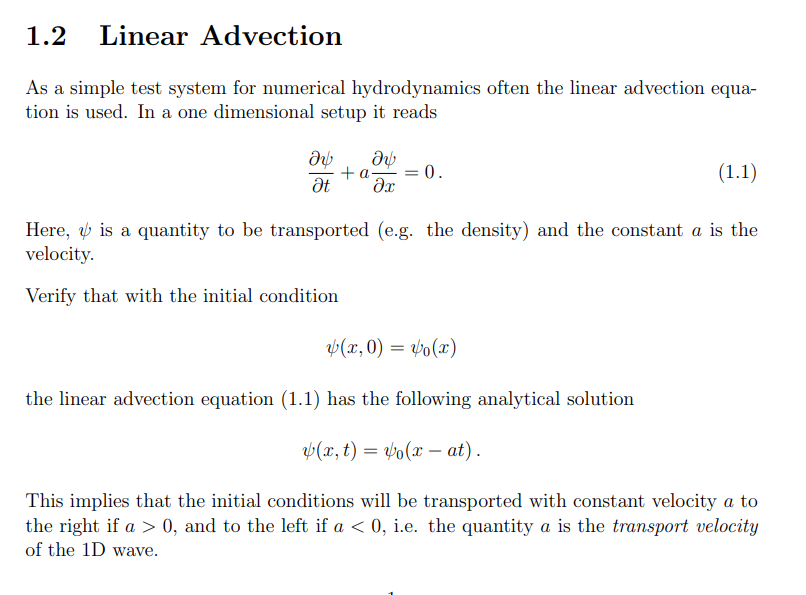

In [ ]:
import math
def U_analytical(X,T):
  a = 0.01/np.pi
  X = np.array(X)
  T = np.array(T)
  # U_ana = np.sin(np.pi*X)*(X + a*T)    # taking Ψo = -math.sin(math.pi*x)
  U_ana = -np.sin(np.pi*(X - a*T))  
  return U_ana

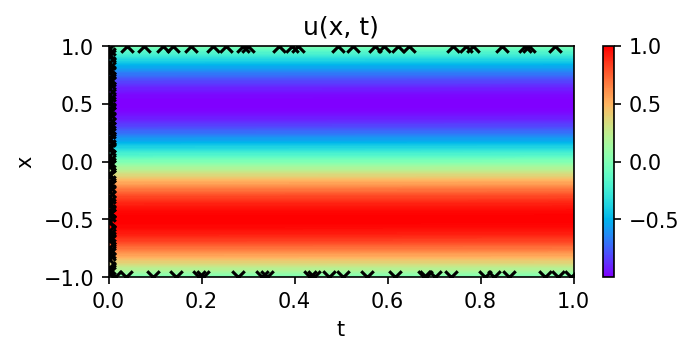

In [ ]:
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
# X = tf.convert_to_tensor(X)
# T = tf.convert_to_tensor(T)
# X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=150)
S = U_analytical(X,T)
S = S.reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

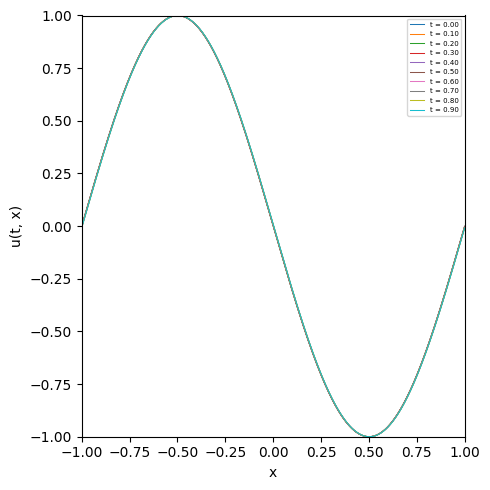

In [ ]:
# make a function `u(t, x)` to use model easier
u = lambda t, x: U_analytical(x,t)

plt.figure(figsize=(5, 5), dpi=100)
# input shape
n_temporal, n_spatial = 10, 2000
# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)
# change t
for i in range(n_temporal):
    v[:, 0] = i/n_temporal
    plt.plot(v[:, 1], U_analytical(v[:,1],v[:,0]), label=f"t = {i/n_temporal:.2f}", lw=0.75)

plt.legend(loc="upper right", fontsize=5)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.show()

## Comparison between analytical and PINNs solution

In [ ]:
n, m = 100, 200
X = np.linspace(-1, +1, m).reshape((-1,1))
T = np.zeros((m,1))

S = U_analytical(X,T)




63/63 [==============================] - 0s 2ms/step


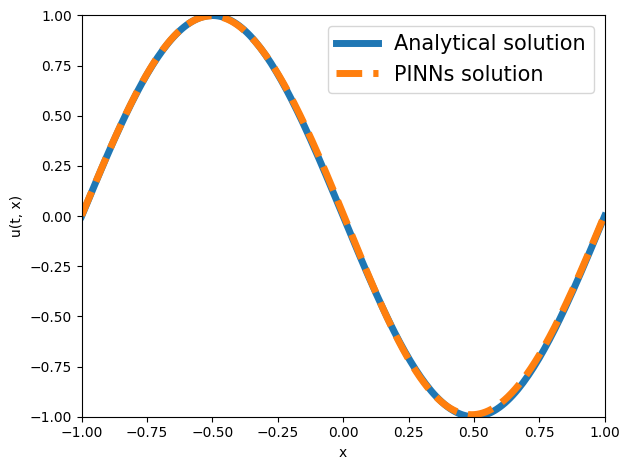

In [ ]:
n, m = 100, 200
X = np.linspace(-1, +1, m).reshape((-1,1))
T = np.zeros((m,1))

S = U_analytical(X,T)

plt.plot(X , S  , label = "Analytical solution" , lw = 5)

n_temporal, n_spatial = 10, 2000
# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)
v[:, 0] = 0
plt.plot(v[:, 1], model.predict(v), label="PINNs solution", lw=5 , linestyle='--')
plt.legend(loc="upper right", fontsize=15)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.show()

### we can see that exact and solution predicted by PINNs are almost same